<a href="https://colab.research.google.com/github/Mfys212/Generasi-Information-Teks-from-Kompas/blob/main/Generasi_Teks_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install pyspark
!pip install pytorch-accelerated
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 653.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 4.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manyl

In [18]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, size, col, to_timestamp
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import requests
import os
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

In [4]:
def download_file(url, file_name):
  response = requests.get(url)
  with open(file_name, 'wb') as f:
    f.write(response.content)

github_url = "https://github.com/Mfys212/Generasi-Information-Teks-from-Kompas/raw/main/"
file_names = ["ai.csv", "algoritma.csv", "biologi.csv", "data (3).csv",
              "fisika.csv", "kimia.csv", "komputer.csv", "matematika.csv",
              "pemrograman.csv", "sains.csv", "statistika.csv",
              "teknik.csv", "teknologi.csv"]

if not os.path.exists("downloaded_files"):
  os.makedirs("downloaded_files")

for file_name in file_names:
  file_url = github_url + file_name
  file_path = os.path.join("downloaded_files", file_name)
  print(f"downloading {file_name} ....")
  download_file(file_url, file_path)

downloading ai.csv ....
downloading algoritma.csv ....
downloading biologi.csv ....
downloading data (3).csv ....
downloading fisika.csv ....
downloading kimia.csv ....
downloading komputer.csv ....
downloading matematika.csv ....
downloading pemrograman.csv ....
downloading sains.csv ....
downloading statistika.csv ....
downloading teknik.csv ....
downloading teknologi.csv ....


In [12]:
df = pd.read_csv("/content/downloaded_files/" + file_names[0])

for file_name in file_names[1:]:
  df_ = pd.read_csv("/content/downloaded_files/" + file_name)
  df = pd.concat([df, df_], ignore_index=True)

spark = SparkSession.builder \
    .appName("Kompas Data") \
    .getOrCreate()

df = spark.createDataFrame(df)

df.printSchema()
df.show()

root
 |-- Tanggal: string (nullable = true)
 |-- Judul: string (nullable = true)
 |-- Konten: string (nullable = true)
 |-- Link: string (nullable = true)

+-------------------+--------------------+--------------------+--------------------+
|            Tanggal|               Judul|              Konten|                Link|
+-------------------+--------------------+--------------------+--------------------+
|2024-05-09 14:30:00|Kontroversi Reka ...|LONDON, KOMPAS.co...|http://www.kompas...|
|2024-05-06 10:31:00|X Twitter Rilis F...|KOMPAS.com- Media...|http://tekno.komp...|
|2024-05-06 15:01:00|Mengenal Gemini A...|KOMPAS.com- Artif...|http://tekno.komp...|
|2024-05-11 10:05:00|Siapkan Generasi ...|KOMPAS.com -Sekol...|http://www.kompas...|
|2024-05-06 12:41:00|[HOAKS] Foto Rest...|hoaks!Berdasarkan...|http://www.kompas...|
|2024-05-10 15:35:00|[HOAKS] Foto Riha...|hoaks!Berdasarkan...|http://www.kompas...|
|2024-05-07 17:58:00|Hoaks, Spongebob ...|KOMPAS.com- Sebua...|http://www.kompa

In [11]:
num_rows = df.count()
all_content = "\n".join(df.select("Konten").rdd.map(lambda row: row[0]).collect())

with open("file.txt", "w") as file:
  file.write(all_content)

with open("file.txt", "r") as file:
  content = file.read()

words = content.split()
num_words = len(words)

df = df.withColumn("Tanggal", to_timestamp("Tanggal", "yyyy-MM-dd HH:mm:ss"))
min_date = df.select("tanggal").agg({"tanggal": "min"}).collect()[0][0]
max_date = df.select("tanggal").agg({"tanggal": "max"}).collect()[0][0]

print("Jumlah berita:", num_rows)
print("Jumlah kata dalam berita:", num_words)
print("Berita paling lama:", min_date)
print("Berita paling baru:", max_date)

Jumlah berita: 28839
Jumlah kata dalam berita: 8913668
Berita paling lama: 2013-05-03 15:58:00
Berita paling baru: 2024-05-12 21:00:00


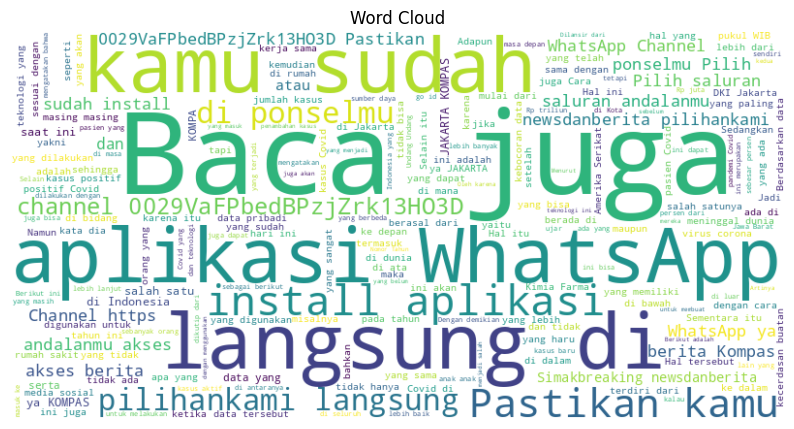

In [16]:
with open("file.txt", "r") as file:
  content = file.read()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(content)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('indonesian-nlp/gpt2-medium-indonesian')
model = GPT2LMHeadModel.from_pretrained('indonesian-nlp/gpt2-medium-indonesian')

train_data_file = "file.txt"
train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=train_data_file,
    block_size=128
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

training_args = TrainingArguments(
    output_dir="/content",
    overwrite_output_dir=True,
    num_train_epochs=500,
    per_device_train_batch_size=4,
    save_steps=10_000,
    save_total_limit=2,
    prediction_loss_only=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

trainer.train()
config = GPT2Config()
trainer.save_model("/content")
config.save_pretrained("/content")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/207 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/467k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/864 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.44G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


Step,Training Loss


In [ ]:
# from transformers import pipeline, set_seed
# generator = pipeline('text-generation', model='indonesian-nlp/gpt2-medium-indonesian')
# set_seed(42)
# generator("Hai saya orang indonesia,", max_length=30, num_return_sequences=5)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Hai saya orang indonesia, mau tanya,apa betul produk tersebut adalah produk indonesia,saya ingin beli produk tersebut,saya tinggal di jakarta, dan saya baru'},
 {'generated_text': 'Hai saya orang indonesia, saat ini saya baru mulai mencari jalan keluar dari sebuah kemiskinan. bagaimana saya mau kaya kalau hidup miskin, apakah saya bisa mencari sesuatu'},
 {'generated_text': 'Hai saya orang indonesia,saya ingin bertanya,jika di jawa tengah,persib bandung atau persib vs arema ada berita baru dan siaran langsung nya'},
 {'generated_text': 'Hai saya orang indonesia, ingin bekerja untuk negeri ini untuk membangun negara yang kita cintai. Saya senang menulis, jadi ketika saya ada waktu luang saya akan menulis'},
 {'generated_text': 'Hai saya orang indonesia,saya berumur 16th, saya tinggal dibogor.apakah bisa saya bergabung menjadi anggota komunitas ini?\nBisa saja, tapi untuk'}]